In [ ]:
!pip install --upgrade --no-cache-dir --force-reinstall numpy==1.23.5 --only-binary=:all:

In [1]:
!pip install loguru cython lap onnxruntime numpy scipy opencv-python cython_bbox
!pip install motmetrics
!pip install deep_sort_realtime
!pip install opencv-python-headless 
!pip install ultralytics
!pip install filterpy

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 42.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 98.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.8 MB/s eta 0:00:00
  Created wheel for cython_bbox: filename=cython_bbox-0.1.5-cp310-cp310-linux_x86_64.whl size=99090 sha256=a8f101f53e4533aa8fb197bcfad723feb040dc79568ad889bfffc77f7e7c9bc8
  Stored in directory: /root/.cache/pip/wheels/c0/b7/68/bab98b7180cda501101a57fb7d36884218ad45ec60c27cd679
Successfully built cython_bbox
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.5/161.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 73.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 22.2 MB/s eta 0:

In [2]:
!git clone https://github.com/ifzhang/ByteTrack.git
%cd ByteTrack
!pip install -r requirements.txt
!python setup.py develop

Cloning into 'ByteTrack'...
remote: Enumerating objects: 2007, done.
remote: Total 2007 (delta 0), reused 0 (delta 0), pack-reused 2007 (from 1)
Receiving objects: 100% (2007/2007), 79.60 MiB | 45.59 MiB/s, done.
Resolving deltas: 100% (1141/1141), done.
/kaggle/working/ByteTrack
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 63.7 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: Could not find a version that satisfies the requirement onnxruntime==1.8.0 (from versions: 1.12.0, 1.12.1, 1.13.1, 1.14.0, 1.14.1, 1.15.0, 1.15.1, 1.16.0, 1.16.1, 1.16.2, 1.16.3, 1.17.0, 1.17.1, 1.17.3, 1.18.0, 1.18.1, 1.19.0, 1.19.2, 1.20.0, 1.20.1)
ERROR: No matching distribution found for onnxruntime==1.8.0
/usr/local/lib/python3.10/dist-packages/setuptools/command/develop.py:41: EasyInstallDeprecationWarning: easy_install command is depr

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
from ultralytics import YOLO
from yolox.tracker.byte_tracker import BYTETracker
from collections import namedtuple
import torch

IMAGE_FOLDER = "/kaggle/input/sportsmot/sportsmot_publish/dataset/val/v_dw7LOz17Omg_c067/img1"
CSV_OUTPUT = "tracking_results_bytetrack.csv"

model = YOLO("/kaggle/input/bl/other/default/1/best.pt")

class TrackerArgs:
    def __init__(self):
        self.track_thresh = 0.3
        self.track_buffer = 40
        self.match_thresh = 0.8
        self.mot20 = False

args = TrackerArgs()
tracker = BYTETracker(args)

frames = sorted(os.listdir(IMAGE_FOLDER))
tracking_results = []

first_frame = cv2.imread(os.path.join(IMAGE_FOLDER, frames[0]))
height, width, _ = first_frame.shape

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter("output_bytetrack.mp4", fourcc, 25, (width, height))

for frame_id, frame_name in enumerate(frames, start=1):
    frame_path = os.path.join(IMAGE_FOLDER, frame_name)
    frame = cv2.imread(frame_path)

    if frame is None:
        print(f"Skipping {frame_name}, could not load.")
        continue

    results = model(frame, verbose=False)[0]

    detections = []
    for result in results.boxes.data.tolist():
        x1, y1, x2, y2, conf, cls_id = result
        detections.append([x1, y1, x2, y2, conf])

    detections = torch.tensor(detections, dtype=torch.float32)

    for d in detections:
        d[4] = max(d[4], 0.5)

    if len(detections) > 0:
        img_size = frame.shape[:2]
        img_info = (img_size[0], img_size[1], frame_id)

        online_targets = tracker.update(detections, img_info, img_size)

        for t in online_targets:
            track_id = t.track_id
            x1, y1, w, h = map(int, t.tlwh)
            x2, y2 = x1 + w, y1 + h

            tracking_results.append([frame_id, track_id, x1, y1, x2-x1, y2-y1, t.score, 1, 1])

            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, f'ID: {track_id}', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    out.write(frame)


out.release()

df = pd.DataFrame(tracking_results, columns=['frame', 'id', 'x', 'y', 'w', 'h', 'conf', 'class', 'vis'])
df.to_csv(CSV_OUTPUT, index=False, header=False)

print(f"Tracking complete.")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/kaggle/working/ByteTrack/yolox/tracker/byte_tracker.py:182: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  dets_second = bboxes[inds_second]
/kaggle/working/ByteTrack/yolox/tracker/byte_tracker.py:185: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  scores_second = scores[inds_second]


Tracking complete.


In [4]:
import motmetrics as mm
import pandas as pd

def load_mot_data(file_path):
    columns = ['frame', 'id', 'x', 'y', 'w', 'h', 'conf', 'class', 'vis']
    df = pd.read_csv(file_path, names=columns)
    df = df[['frame', 'id', 'x', 'y', 'w', 'h']]
    return df

gt_file = "/kaggle/input/sportsmot/sportsmot_publish/dataset/val/v_dw7LOz17Omg_c067/gt/gt.txt"
pred_file = "/kaggle/working/ByteTrack/tracking_results_bytetrack.csv"

gt_data = load_mot_data(gt_file)
pred_data = load_mot_data(pred_file)

In [5]:
acc = mm.MOTAccumulator(auto_id=True)

for frame in sorted(gt_data['frame'].unique()):
    gt_frame = gt_data[gt_data['frame'] == frame]
    pred_frame = pred_data[pred_data['frame'] == frame]

    gt_ids = list(gt_frame['id'])
    pred_ids = list(pred_frame['id'])

    distances = mm.distances.iou_matrix(
        gt_frame[['x', 'y', 'w', 'h']].values,
        pred_frame[['x', 'y', 'w', 'h']].values,
        max_iou=0.5
    )

    acc.update(gt_ids, pred_ids, distances)

mh = mm.metrics.create()

summary_bytetrack = mh.compute(acc, metrics=['idf1', 'mota', 'precision'], name='MOT Evaluation')

print(summary_bytetrack)


                  idf1      mota  precision
MOT Evaluation  0.6908  0.882885   0.957164


In [6]:
import random

val_folder = "/kaggle/input/sportsmot/sportsmot_publish/dataset/val/"

video_list_file = "/kaggle/input/sportsmot/sportsmot_publish/splits_txt/football.txt"

with open(video_list_file, "r") as f:
    video_names = [line.strip() for line in f.readlines() if line.strip()]


selected_folders = [os.path.join(val_folder, v) for v in video_names if os.path.isdir(os.path.join(val_folder, v))]

num_test = 5

random.seed(42)
selected_folders = random.sample(selected_folders, num_test)

summary_list_bytetrack = []

for video_folder in selected_folders:
    print(f"Processing video: {video_folder}")


    IMAGE_FOLDER = os.path.join(video_folder, "img1")
    CSV_OUTPUT = f"tracking_results_bytetrack_{os.path.basename(video_folder)}.csv"
    gt_file = os.path.join(video_folder, "gt", "gt.txt")

    model = YOLO("/kaggle/input/bl/other/default/1/best.pt")

    class TrackerArgs:
        def __init__(self):
            self.track_thresh = 0.3
            self.track_buffer = 40
            self.match_thresh = 0.8
            self.mot20 = False

    args = TrackerArgs()
    tracker = BYTETracker(args)

    frames = sorted(os.listdir(IMAGE_FOLDER))
    tracking_results = []

    first_frame = cv2.imread(os.path.join(IMAGE_FOLDER, frames[0]))
    height, width, _ = first_frame.shape


    output_video_path = f"tracking_output_bytetrack_{os.path.basename(video_folder)}.mp4"
    out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), 25, (height, width))

    for frame_id, frame_name in enumerate(frames, start=1):
        frame_path = os.path.join(IMAGE_FOLDER, frame_name)
        frame = cv2.imread(frame_path)

        if frame is None:
            print(f"Skipping {frame_name}, could not load.")
            continue

        results = model(frame, verbose=False)[0]

        detections = []
        for result in results.boxes.data.tolist():
            x1, y1, x2, y2, conf, cls_id = result
            detections.append([x1, y1, x2, y2, conf])

        detections = torch.tensor(detections, dtype=torch.float32)

        for d in detections:
            d[4] = max(d[4], 0.5)

        if len(detections) > 0:
            img_size = frame.shape[:2]
            img_info = (img_size[0], img_size[1], frame_id)

            online_targets = tracker.update(detections, img_info, img_size)

            for t in online_targets:
                track_id = t.track_id
                x1, y1, w, h = map(int, t.tlwh)
                x2, y2 = x1 + w, y1 + h

                tracking_results.append([frame_id, track_id, x1, y1, x2-x1, y2-y1, t.score, 1, 1])

                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frame, f'ID: {track_id}', (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    out.write(frame)


    out.release()

    df = pd.DataFrame(tracking_results, columns=['frame', 'id', 'x', 'y', 'w', 'h', 'conf', 'class', 'vis'])
    df.to_csv(CSV_OUTPUT, index=False, header=False)
    print(f"Tracking complete for {video_folder}. Output saved as {output_video_path}")

    
    gt_data = load_mot_data(gt_file)
    pred_data = load_mot_data(CSV_OUTPUT)

    acc = mm.MOTAccumulator(auto_id=True)

    for frame in sorted(gt_data['frame'].unique()):
        gt_frame = gt_data[gt_data['frame'] == frame]
        pred_frame = pred_data[pred_data['frame'] == frame]

        gt_ids = list(gt_frame['id'])
        pred_ids = list(pred_frame['id'])

        distances = mm.distances.iou_matrix(
            gt_frame[['x', 'y', 'w', 'h']].values,
            pred_frame[['x', 'y', 'w', 'h']].values,
            max_iou=0.5
        )

        acc.update(gt_ids, pred_ids, distances)

    mh = mm.metrics.create()

    summary_bytetrack = mh.compute(acc, metrics=['idf1', 'mota', 'precision'], name='MOT Evaluation')
    summary_list_bytetrack.append(summary_bytetrack)

    print(summary_bytetrack)

print("All tracking processes completed.")

bytetrack_mean = pd.concat(summary_list_bytetrack, ignore_index=True).mean()
print(bytetrack_mean)

Processing video: /kaggle/input/sportsmot/sportsmot_publish/dataset/val/v_dw7LOz17Omg_c067


/kaggle/working/ByteTrack/yolox/tracker/byte_tracker.py:182: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  dets_second = bboxes[inds_second]
/kaggle/working/ByteTrack/yolox/tracker/byte_tracker.py:185: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  scores_second = scores[inds_second]


Tracking complete for /kaggle/input/sportsmot/sportsmot_publish/dataset/val/v_dw7LOz17Omg_c067. Output saved as tracking_output_bytetrack_v_dw7LOz17Omg_c067.mp4
                  idf1      mota  precision
MOT Evaluation  0.6908  0.882885   0.957164
Processing video: /kaggle/input/sportsmot/sportsmot_publish/dataset/val/v_G-vNjfx1GGc_c004


/kaggle/working/ByteTrack/yolox/tracker/byte_tracker.py:182: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  dets_second = bboxes[inds_second]
/kaggle/working/ByteTrack/yolox/tracker/byte_tracker.py:185: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  scores_second = scores[inds_second]


Tracking complete for /kaggle/input/sportsmot/sportsmot_publish/dataset/val/v_G-vNjfx1GGc_c004. Output saved as tracking_output_bytetrack_v_G-vNjfx1GGc_c004.mp4
                    idf1      mota  precision
MOT Evaluation  0.560165  0.829667     0.9346
Processing video: /kaggle/input/sportsmot/sportsmot_publish/dataset/val/v_2QhNRucNC7E_c017


/kaggle/working/ByteTrack/yolox/tracker/byte_tracker.py:182: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  dets_second = bboxes[inds_second]
/kaggle/working/ByteTrack/yolox/tracker/byte_tracker.py:185: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  scores_second = scores[inds_second]


Tracking complete for /kaggle/input/sportsmot/sportsmot_publish/dataset/val/v_2QhNRucNC7E_c017. Output saved as tracking_output_bytetrack_v_2QhNRucNC7E_c017.mp4
                    idf1      mota  precision
MOT Evaluation  0.693007  0.796436   0.919994
Processing video: /kaggle/input/sportsmot/sportsmot_publish/dataset/val/v_i2_L4qquVg0_c006


/kaggle/working/ByteTrack/yolox/tracker/byte_tracker.py:182: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  dets_second = bboxes[inds_second]
/kaggle/working/ByteTrack/yolox/tracker/byte_tracker.py:185: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  scores_second = scores[inds_second]


Tracking complete for /kaggle/input/sportsmot/sportsmot_publish/dataset/val/v_i2_L4qquVg0_c006. Output saved as tracking_output_bytetrack_v_i2_L4qquVg0_c006.mp4
                    idf1      mota  precision
MOT Evaluation  0.617412  0.823025   0.905695
Processing video: /kaggle/input/sportsmot/sportsmot_publish/dataset/val/v_G-vNjfx1GGc_c601


/kaggle/working/ByteTrack/yolox/tracker/byte_tracker.py:182: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  dets_second = bboxes[inds_second]
/kaggle/working/ByteTrack/yolox/tracker/byte_tracker.py:185: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  scores_second = scores[inds_second]


Tracking complete for /kaggle/input/sportsmot/sportsmot_publish/dataset/val/v_G-vNjfx1GGc_c601. Output saved as tracking_output_bytetrack_v_G-vNjfx1GGc_c601.mp4
                    idf1      mota  precision
MOT Evaluation  0.546067  0.691574   0.863352
All tracking processes completed.
idf1         0.621490
mota         0.804717
precision    0.916161
dtype: float64


In [7]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

from deep_sort_realtime.deepsort_tracker import DeepSort
from ultralytics import YOLO

In [8]:
model = YOLO("/kaggle/input/bl/other/default/1/best.pt")

def detect_objects(frame):
    results = model(frame, verbose=False)

    detections = []
    for i, box in enumerate(results[0].boxes.xywh):
        detections.append((box.tolist(), float(results[0].boxes.conf[i]), int(results[0].boxes.cls[i])))
    
    return detections

In [9]:
tracker = DeepSort(max_age=30,
                   n_init=3,
                   nms_max_overlap=1.0,
                   max_cosine_distance=0.5,
                   nn_budget=None,
                   override_track_class=None)

In [10]:
IMAGE_FOLDER = '/kaggle/input/sportsmot/sportsmot_publish/dataset/val/v_dw7LOz17Omg_c067/img1'
CSV_OUTPUT = "tracking_results_deepsort.csv"

frames = sorted(os.listdir(IMAGE_FOLDER)) 

first_frame = cv2.imread(os.path.join(IMAGE_FOLDER, frames[0]))
height, width, _ = first_frame.shape
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter("output_deepsort.mp4", fourcc, 25, (width, height))

tracking_results = []

for frame_id, frame_name in enumerate(frames):
    frame_path = os.path.join(IMAGE_FOLDER, frame_name)
    frame = cv2.imread(frame_path)
    
    detections = detect_objects(frame)
    
   
    tracks = tracker.update_tracks(detections, frame=frame)

    for track in tracks:
        if not track.is_confirmed():
            continue

        bbox = track.to_ltwh()  
        x, y, w, h = map(int, bbox)
        x, y = x-w/2, y-h/2

        track_id = track.track_id
        tracking_results.append([frame_id, track_id, x, y, w, h, 1, 1, 1])
        
        x, y = int(x), int(y)
        
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(frame, f"ID: {track_id}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, (0, 255, 0), 2)
    
    out.write(frame)
    

df = pd.DataFrame(tracking_results, columns=['frame', 'id', 'x', 'y', 'w', 'h', 'conf', 'class', 'vis'])
df.to_csv(CSV_OUTPUT, index=False, header=False)

out.release()
print("Completed!")

Completed!


In [11]:
import motmetrics as mm
import pandas as pd

def load_mot_data(file_path):
    columns = ['frame', 'id', 'x', 'y', 'w', 'h', 'conf', 'class', 'vis']
    df = pd.read_csv(file_path, names=columns)
    df = df[['frame', 'id', 'x', 'y', 'w', 'h']]
    return df

gt_file = "/kaggle/input/sportsmot/sportsmot_publish/dataset/val/v_dw7LOz17Omg_c067/gt/gt.txt"  # Change to your GT file path
pred_file = "/kaggle/working/ByteTrack/tracking_results_deepsort.csv"

gt_data = load_mot_data(gt_file)
pred_data = load_mot_data(pred_file)

In [12]:
acc = mm.MOTAccumulator(auto_id=True)

for frame in sorted(gt_data['frame'].unique()):
    gt_frame = gt_data[gt_data['frame'] == frame]
    pred_frame = pred_data[pred_data['frame'] == frame]

    gt_ids = list(gt_frame['id'])
    pred_ids = list(pred_frame['id'])

    distances = mm.distances.iou_matrix(
        gt_frame[['x', 'y', 'w', 'h']].values,
        pred_frame[['x', 'y', 'w', 'h']].values,
        max_iou=0.5
    )

    acc.update(gt_ids, pred_ids, distances)

mh = mm.metrics.create()

summary_deepsort = mh.compute(acc, metrics=['idf1', 'mota', 'precision'], name='MOT Evaluation')

print(summary_deepsort)

                    idf1      mota  precision
MOT Evaluation  0.598474  0.453657   0.677144


In [13]:
summary_list_deepsort = []

for video_folder in selected_folders:
    print(f"Processing video: {video_folder}")

    tracker = DeepSort(max_age=30,
                   n_init=3,
                   nms_max_overlap=1.0,
                   max_cosine_distance=0.5,
                   nn_budget=None,
                   override_track_class=None)

    IMAGE_FOLDER = os.path.join(video_folder, "img1")
    CSV_OUTPUT = f"tracking_results_deepsort_{os.path.basename(video_folder)}.csv"
    gt_file = os.path.join(video_folder, "gt", "gt.txt")


    frames = sorted(os.listdir(IMAGE_FOLDER)) 

    first_frame = cv2.imread(os.path.join(IMAGE_FOLDER, frames[0]))
    height, width, _ = first_frame.shape
    
    output_video_path = f"tracking_output_deepsort_{os.path.basename(video_folder)}.mp4"
    out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), 25, (height, width))


    tracking_results = []

    for frame_id, frame_name in enumerate(frames):
        frame_path = os.path.join(IMAGE_FOLDER, frame_name)
        frame = cv2.imread(frame_path)
    
        detections = detect_objects(frame)
    
   
        tracks = tracker.update_tracks(detections, frame=frame)

        for track in tracks:
            if not track.is_confirmed():
                continue

            bbox = track.to_ltwh()  
            x, y, w, h = map(int, bbox)
            x, y = x-w/2, y-h/2

            track_id = track.track_id
            tracking_results.append([frame_id, track_id, x, y, w, h, 1, 1, 1])
        
            x, y = int(x), int(y)
        
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(frame, f"ID: {track_id}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, (0, 255, 0), 2)
    
        out.write(frame)
    

    df = pd.DataFrame(tracking_results, columns=['frame', 'id', 'x', 'y', 'w', 'h', 'conf', 'class', 'vis'])
    df.to_csv(CSV_OUTPUT, index=False, header=False)

    out.release()

    print(f"Tracking complete for {video_folder}. Output saved as {output_video_path}")

    
    gt_data = load_mot_data(gt_file)
    pred_data = load_mot_data(CSV_OUTPUT)

    acc = mm.MOTAccumulator(auto_id=True)

    for frame in sorted(gt_data['frame'].unique()):
        gt_frame = gt_data[gt_data['frame'] == frame]
        pred_frame = pred_data[pred_data['frame'] == frame]

        gt_ids = list(gt_frame['id'])
        pred_ids = list(pred_frame['id'])

        distances = mm.distances.iou_matrix(
            gt_frame[['x', 'y', 'w', 'h']].values,
            pred_frame[['x', 'y', 'w', 'h']].values,
            max_iou=0.5
        )

        acc.update(gt_ids, pred_ids, distances)

    mh = mm.metrics.create()

    summary_deepsort = mh.compute(acc, metrics=['idf1', 'mota', 'precision'], name='MOT Evaluation')
    summary_list_deepsort.append(summary_deepsort)

    print(summary_deepsort)

print("All tracking processes completed.")

deepsort_mean = pd.concat(summary_list_deepsort, ignore_index=True).mean()

print(deepsort_mean)

Processing video: /kaggle/input/sportsmot/sportsmot_publish/dataset/val/v_dw7LOz17Omg_c067
Tracking complete for /kaggle/input/sportsmot/sportsmot_publish/dataset/val/v_dw7LOz17Omg_c067. Output saved as tracking_output_deepsort_v_dw7LOz17Omg_c067.mp4
                    idf1      mota  precision
MOT Evaluation  0.598474  0.453657   0.677144
Processing video: /kaggle/input/sportsmot/sportsmot_publish/dataset/val/v_G-vNjfx1GGc_c004
Tracking complete for /kaggle/input/sportsmot/sportsmot_publish/dataset/val/v_G-vNjfx1GGc_c004. Output saved as tracking_output_deepsort_v_G-vNjfx1GGc_c004.mp4
                    idf1      mota  precision
MOT Evaluation  0.429404  0.356765   0.636689
Processing video: /kaggle/input/sportsmot/sportsmot_publish/dataset/val/v_2QhNRucNC7E_c017
Tracking complete for /kaggle/input/sportsmot/sportsmot_publish/dataset/val/v_2QhNRucNC7E_c017. Output saved as tracking_output_deepsort_v_2QhNRucNC7E_c017.mp4
                    idf1     mota  precision
MOT Evaluation  0.

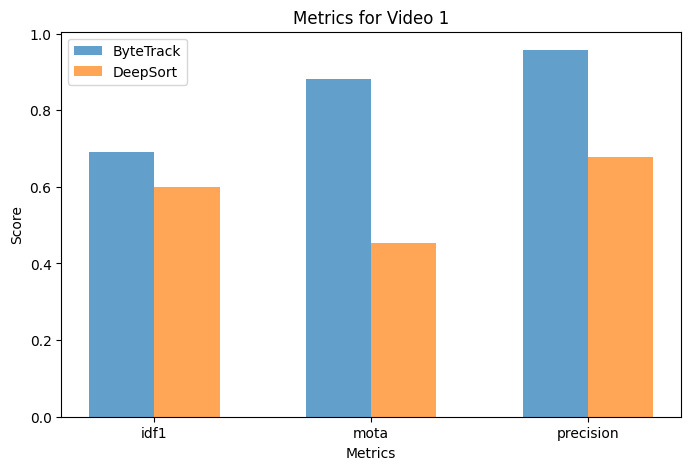

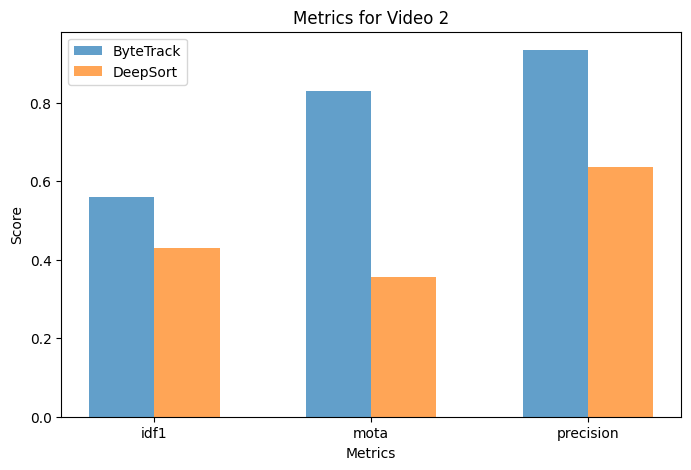

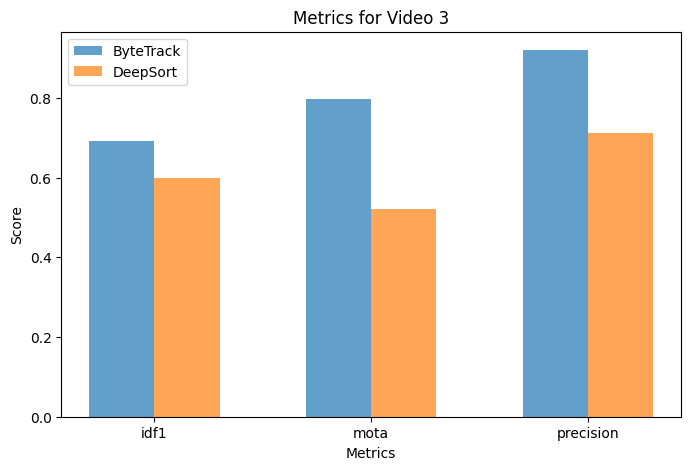

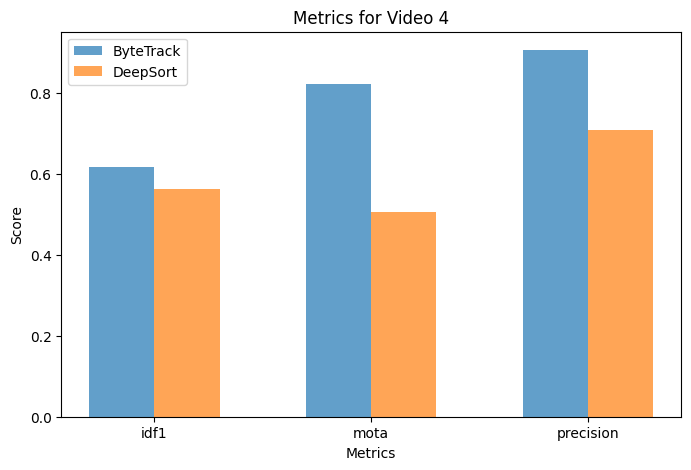

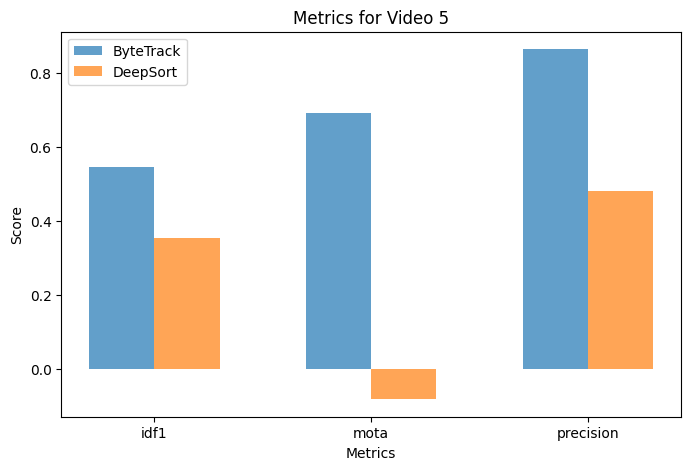

In [20]:
bytetrack_dfs = summary_list_bytetrack
deepsort_dfs = summary_list_deepsort

video_names = [f"Video {i+1}" for i in range(len(bytetrack_dfs))]

metrics = ['idf1', 'mota', 'precision']
x = np.arange(3)
width = 0.3

for i, (bt_df, ds_df) in enumerate(zip(bytetrack_dfs, deepsort_dfs)):
    bt_metrics = bt_df.mean()
    ds_metrics = ds_df.mean()

    
    fig, ax = plt.subplots(figsize=(8, 5))

    ax.bar(x - width/2, bt_metrics[metrics], width, label='ByteTrack', alpha=0.7)
    ax.bar(x + width/2, ds_metrics[metrics], width, label='DeepSort', alpha=0.7)

    ax.set_xlabel("Metrics")
    ax.set_ylabel("Score")
    ax.set_title(f"Metrics for {video_names[i]}")
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    plt.show()
